In [797]:
import pandas as pd
import numpy as np
from pycox.datasets import support
from sksurv import nonparametric
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
import collections

This dataset is used for George Chen's npsurvival paper (https://www.andrew.cmu.edu/user/georgech/papers/Survival%20Topic%20Models.pdf).

There are $1,011$ patients observed at different steps.


Focusing only on the first visit, a patient is fully observed iff between the time they were admitted into and released outside of ICU, they did not pass away. Some special case: deceased after release?? Afterwards, I dropped patients who live beyond 200 years (weird encoding). I'm left with 956 patients. 



In [798]:
df = pd.read_csv("/Users/lerdp/Desktop/ich_topicmodeling/ich_preprocess.csv", sep = ",")

In [799]:
def extractBasicInfo(df, pt_id):
    """
    @param df: EHR
    @param pt_id: Patient id
    Use: Return patient's 
    - (FIRST) age when admitted
    - ethnic 
    - gender
    - time in icu (days)
    - whether a patient is deceased
    Note: I have checked that every patient, once admitted, is released from ICU. 
    """
    # Demographic info
    second_per_year = 365.25*24*60*60
    temp = df[df["pt"] == pt_id]
    birth_index = temp[temp["event"] == "birthed"].index[0]
    ethnic_index = birth_index+1
    gender_index = birth_index+2
    birth = temp.loc[birth_index]["t"]
    gender = temp.loc[gender_index]["event"].strip("gender:")
    ethnic = temp.loc[ethnic_index]["event"].strip("ethnicity:")
    
    # Calculate age of admittance, time_in_icu
    in_m_out = 0
    de_m_in = 0 
    try:
        inicu =  temp[temp["event"] == "inicu"]["t"].tolist()[0]
        outicu =  temp[temp["event"] == "outicu"]["t"].tolist()[0]
        age_at_admit = round((inicu-birth)/second_per_year, 2)
        time_in_icu = round((outicu-inicu)*365.25/second_per_year, 4)
        if inicu > outicu: 
            in_m_out = 1
    except:
        print("Patient %d never admitted" %(pt_id))
        return [999,999,999,999,999,999]
    
    # Extract deceased status and timeline 
    deceased = 0
    if len(temp[temp["event"] == "deceased"]) == 1:
        deceased = 1
        deceased_time = temp[temp["event"] == "deceased"]["t"].tolist()[0]
        if deceased_time < inicu:
            de_m_in = 1
    
    # Calculate the observation status 
    fully_observed = 999
    if len(temp[temp["event"] == "deceased"]) == 0:
        # NOTE: Every patient admitted to ICU was released out of ICU. Therefore, if they were never deceased,
        # we observe their release time. 
        fully_observed = 1
    elif temp[temp["event"] == "deceased"].index[0] > temp[temp["event"] == "outicu"].index[0]:
        # Patients were dead after released from ICU. 
        # TODO: Unsure if this counts as fully observed, because they might be released knowing they would be dead
        # anyway. 
        fully_observed = 1
    else: 
        fully_observed = 0
    
    # Marital status and religion 
    marital_status = None
    religion = None
    
    return_lst = [pt_id, age_at_admit, ethnic, gender, time_in_icu, fully_observed, deceased, in_m_out, de_m_in]
    assert len(return_lst) == 9
    return return_lst

def transformEthnic(df, col_name):
    # After transformation, there will be these ethnic: white, asian, black, latino, other, NA. 
    assert col_name in df.columns.tolist()
    temp = []
    for val in df[col_name].tolist():
        ethnic = ""
        if val in ["white", "asian", "black", "latino", "other", "NA"]:
            ethnic = val
        elif val == "w" or val.find("white") != -1:
            ethnic = "white"
        elif val.find("asia") != -1:
            ethnic = "asian"
        elif val.find("black") != -1:
            ethnic = "black"
        elif val.find("decline") != -1 or val.find("unknown") != -1 or val.find("unable") != -1:
            ethnic = "NA"
        elif val.find("latino") != -1:
            ethnic = "latino"
        else:
            ethnic = "other"
        temp.append(ethnic)
    return temp

In [800]:
col = ["pt", "age_at_admit","ethnic","gender","days_in_icu","fully_observed", "deceased", "in_m_out", "de_m_in"]
newdf = pd.DataFrame(data=None, index=None, columns = col)
for pt in np.sort(df["pt"].value_counts().index):
    try:
        newdf.loc[len(newdf.index)] = extractBasicInfo(df, pt)
    except:
        print(pt)
        print(extractBasicInfo(df, pt))
# Remove nonsense age and transform ethnicity to countable
newdf = newdf[newdf["age_at_admit"] != 999]
newdf = newdf[newdf["age_at_admit"] < 200]
newdf["ethnic"] = transformEthnic(newdf, "ethnic")

Patient 18216 never admitted
18216.0
Patient 18216 never admitted
[999, 999, 999, 999, 999, 999]


In [794]:
newdf.to_csv("summary_data.csv")

In [801]:
# Obtain the boundary of age
dfs = newdf
q1 = dfs.describe()["age_at_admit"]["25%"]
q2 = dfs.describe()["age_at_admit"]["50%"]
q3 = dfs.describe()["age_at_admit"]["75%"]

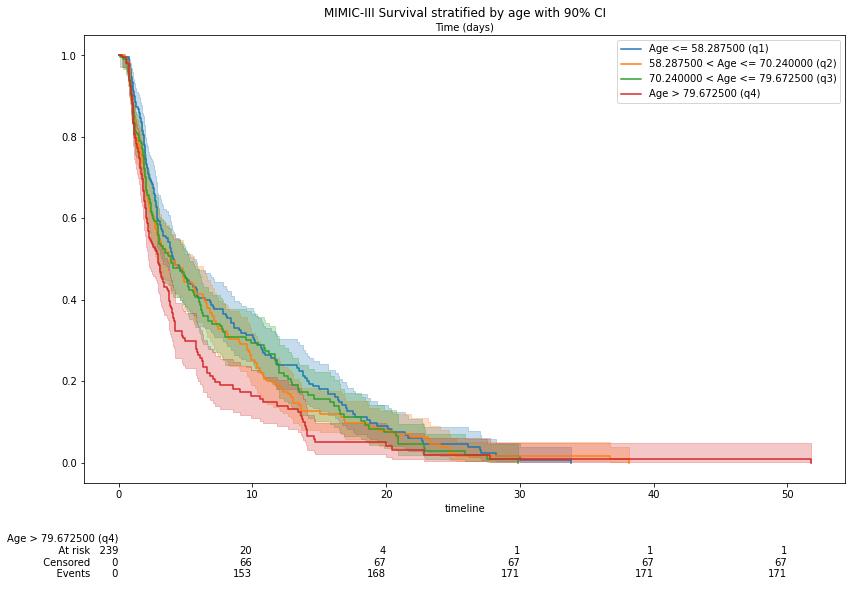

In [802]:
# Age when the patient is admitted. We do not see the survival time stratified like SUPPORt simply because 
var_strat = "age_at_admit"
var_oi = "days_in_icu"
fully_observed = "fully_observed"
dfs1 = dfs[dfs[var_strat] <= q1]
dfs2 = dfs[dfs[var_strat].between(q1,q2)]
dfs3 = dfs[dfs[var_strat].between(q2,q3)]
dfs4 = dfs[dfs[var_strat] > q3]

km = KaplanMeierFitter(alpha = 0.05) ## instantiate the class to create an object
## Fit the data into the model
km.fit(dfs1[var_oi], dfs1[fully_observed], label = "Age <= %f (q1)" %(q1))
km.plot(ci_show = True,  figsize = (12,8))
km.fit(dfs2[var_oi], dfs2[fully_observed], label = "%f < Age <= %f (q2)" %(q1, q2))
km.plot(ci_show=True)
km.fit(dfs3[var_oi], dfs3[fully_observed], label = "%f < Age <= %f (q3)" %(q2, q3))
km.plot(ci_show=True)
km.fit(dfs4[var_oi], dfs4[fully_observed], label = "Age > %f (q4)" %(q3))
km.plot(ci_show=True, at_risk_counts = True)
plt.title('MIMIC-III Survival stratified by age with 90% CI')
plt.ylabel('Survival probability (%)')
plt.xlabel('Time (days)')
plt.savefig("MIMIC-III_survival_by_age.png")

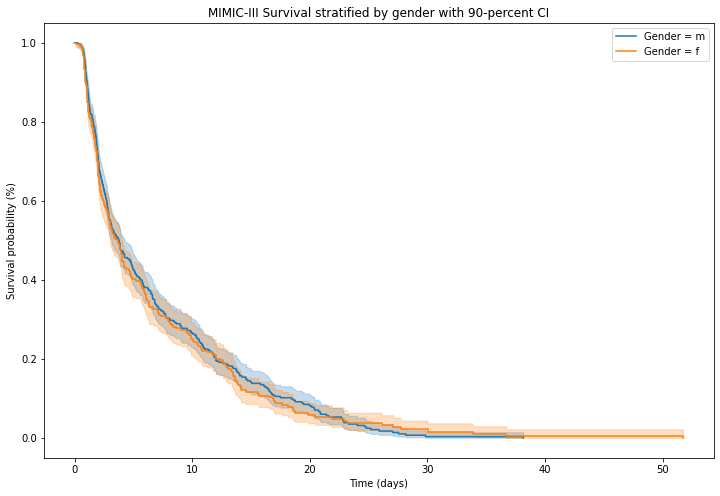

In [803]:
# Gender
var_strat = "gender"
var_oi = "days_in_icu"
fully_observed = "fully_observed"
dfs1 = dfs[dfs[var_strat] == "m"]
dfs2 = dfs[dfs[var_strat] == "f"]

km = KaplanMeierFitter(alpha = 0.1) ## instantiate the class to create an object
## Fit the data into the model
km.fit(dfs1[var_oi], dfs1[fully_observed], label = "Gender = %s" %("m"))
km.plot(ci_show = True,  figsize = (12,8))
km.fit(dfs2[var_oi], dfs2[fully_observed], label = "Gender = %s" %("f"))
km.plot(ci_show=True)
plt.title('MIMIC-III Survival stratified by %s with 90-percent CI' %(var_strat))
plt.ylabel('Survival probability (%)')
plt.xlabel('Time (days)')
plt.savefig("MIMIC-III_age.png")

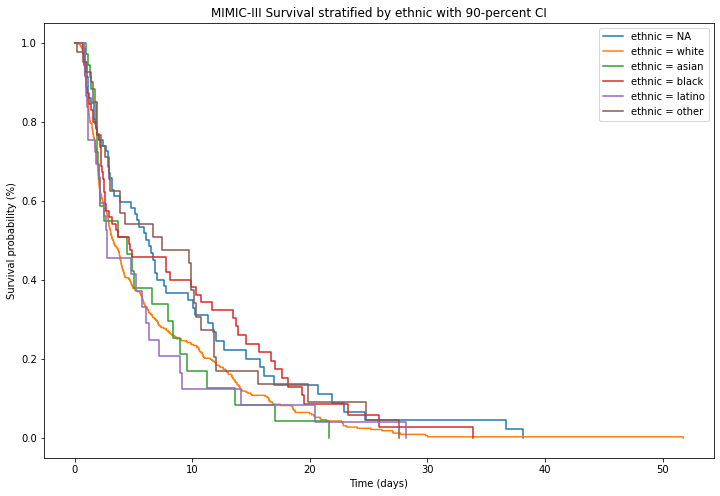

In [804]:
# Ethnic
# Interesting results: The survival-by-age plot shows that survival decreases with respect to age. 
# Ranking by average age at 
# NOTE: latino deviates from the trend. 
var_strat = "ethnic"
var_oi = "days_in_icu"
fully_observed = "fully_observed"
km = KaplanMeierFitter(alpha = 0.1) ## instantiate the class to create an object
for var in newdf[var_strat].unique():
    #if var in ["black","white", "latino"]:
        dfs = newdf[newdf[var_strat] == var]
        km.fit(dfs[var_oi], dfs[fully_observed], label = "%s = %s" %(var_strat, var))
        km.plot(ci_show = False,  figsize = (12,8))
plt.title('MIMIC-III Survival stratified by %s with 90-percent CI' %(var_strat))
plt.ylabel('Survival probability (%)')
plt.xlabel('Time (days)')
plt.savefig("KM-by-ethnic")

In [806]:
# There are 5,926 operations in total that patients ever receive throughout their stay.
# 2,244 operations pre_admittance to ICU.

def hashDict(var_name, var_dict, newdf):
    temp = []
    for pt in newdf["pt"].tolist():
        try:
            temp.append(var_dict[pt])
        except:
            temp.append(None)
    newdf[var_name] = temp
    
temp = df.groupby("event")["pt"].apply(list)
marital_status = []
marital_dict = {}
for event in temp.index.tolist():
    event_type = event.split(":")
    if event_type[0] == "marital_status":
        marital_status.append(event_type[1])
for status_type in marital_status:
    indexer = "marital_status:%s" %(status_type)
    all_status = [status_type] * len(temp[indexer])
    cur = dict(zip(temp[indexer], all_status))
    marital_dict.update(cur)

hashDict("marital_status", marital_dict, newdf)

In [807]:
# Pipeline to extract values of variables interested

var_name_lst = ["religion", "weight", "height", "behavior","judgement", "balance",
 "tidal_volume","hemoglobin","conscious"] # Name of variables to add in newdf
event_name_lst = ["chart:religion:", "chart:admit wt:kg", "chart:height (cm):cm", "chart:behavior:", 
               "chart:judgement:", "chart:balance:", "chart:tidal volume (observed):ml", 
              "chart:hemoglobin:g/dl","chart:level of consciousness:"] # Name of events

assert len(var_name_lst) == len(event_name_lst)

for i, event_name in enumerate(event_name_lst):
    name = var_name_lst[i]
    all_event = df[df["event"] == event_name].drop_duplicates("pt")
    # Subset only patients with which we have events
    all_event = all_event[all_event["pt"].isin(newdf["pt"].tolist())]
    # Create a new column
    event_dict = dict(zip(all_event["pt"], all_event["value"]))
    hashDict(name, event_dict, newdf)

In [822]:
df.groupby("event")["pt"].agg(pd.Series.nunique).sort_values(ascending = False)[51:100]

event
lab:blood:chemistry:sodium               991
chart:urine color:                       991
lab:blood:chemistry:glucose              991
chart:urine appearance:                  987
chart:pain present:                      981
chart:side rails:                        980
chart:dorsal pedpulse right:             974
chart:dorsal pedpulse left:              973
chart:level of consciousness:            967
lab:blood:chemistry:magnesium            967
chart:orientation:                       966
lab:blood:chemistry:phosphate            962
lab:blood:chemistry:calcium, total       955
chart:support systems:                   954
chart:marital status:                    951
chart:pain location:                     949
chart:ru strength/movement:              941
chart:lu strength/movement:              941
chart:ll strength/movement:              941
chart:rl strength/movement:              940
chart:spontaneous movement:              936
chart:hemoglobin:g/dl                    931
char

In [819]:
# Obtain the index when people are first admitted to ICU
inicu = df[df["event"]=="inicu"].drop_duplicates(subset = ["pt"], keep = "first")
time_first_admit = dict(zip(inicu["pt"], inicu.index))

# Create a dataframe of all test run before ICU
# Goal: Understand what happens before
pre_inicu_df = pd.DataFrame(columns = df.columns.tolist())
for pt in df["pt"].unique().tolist():
    if pt != 18216:
        temp = df[df["pt"] == pt]
        temp = temp.loc[:time_first_admit[pt]]
        frame = [pre_inicu_df, temp]
        pre_inicu_df = pd.concat(frame)

In [633]:
time_first_admit

{9.0: 140,
 67.0: 9864,
 81.0: 10306,
 103.0: 16667,
 203.0: 19433,
 304.0: 36098,
 360.0: 36407,
 407.0: 43912,
 561.0: 46246,
 666.0: 51093,
 831.0: 51950,
 854.0: 61728,
 936.0: 66641,
 970.0: 68393,
 1086.0: 101627,
 1220.0: 103368,
 1241.0: 105529,
 1286.0: 149821,
 1328.0: 155036,
 1353.0: 155398,
 1426.0: 159422,
 1428.0: 161674,
 1493.0: 178223,
 1614.0: 180084,
 1630.0: 181748,
 1744.0: 184228,
 1996.0: 194284,
 2149.0: 200324,
 2238.0: 204181,
 2292.0: 215598,
 2310.0: 218001,
 2434.0: 247680,
 2620.0: 251721,
 2845.0: 253262,
 2878.0: 254294,
 2900.0: 259633,
 2921.0: 271934,
 2943.0: 280077,
 2973.0: 333606,
 2993.0: 334476,
 3006.0: 365382,
 3171.0: 389809,
 3189.0: 390986,
 3212.0: 392207,
 3258.0: 428295,
 3289.0: 436732,
 3301.0: 456013,
 3340.0: 458075,
 3497.0: 468918,
 3710.0: 470381,
 3715.0: 477508,
 3733.0: 480862,
 3737.0: 482382,
 3800.0: 504196,
 3831.0: 526671,
 3939.0: 527534,
 3974.0: 553861,
 3977.0: 589083,
 4023.0: 595035,
 4270.0: 596658,
 4336.0: 602125

In [546]:
# Summary statistics of all covariates
def getTest(event):
    temp = event.split(":")
    return temp

# Thoughts: Count should clinical relevance. This doesn't seem true. It depends on how many patients we
covariate = {}
detail_level = 2
for lst in df["event"].apply(getTest).tolist():
    event = ":".join(lst[:detail_level]).strip()
    try: 
        covariate[event] += 1
        if lst[1] == "ct":
            covariate[event] += 9999
    except:
        covariate[event] = 1

[('lab:blood', 436464),
 ('chart:heart rate', 171234),
 ('chart:respiratory rate', 169082),
 ('chart:heart rhythm', 143314),
 ('chart:calprevflg', 92561),
 ('chart:spo2', 92274),
 ('chart:code status', 87154),
 ('chart:ectopy type', 86627),
 ('chart:precautions', 86270),
 ('chart:service type', 77968),
 ('chart:o2 saturation pulseoxymetry', 77365),
 ('chart:level of consciousness', 67384),
 ('chart:safety measures', 65535),
 ('chart:ectopy frequency', 65467),
 ('chart:pupil size right', 64508),
 ('chart:pupil response right', 64269),
 ('chart:arterial bp systolic', 64159),
 ('chart:pupil size left', 64154),
 ('chart:arterial bp diastolic', 63920),
 ('chart:pupil response left', 63903),
 ('chart:orientation', 63828),
 ('chart:arterial bp mean', 63605),
 ('chart:risk for falls', 62290),
 ('chart:spontaneous movement', 62168),
 ('chart:ru strength/movement', 62017),
 ('chart:lu strength/movement', 61908),
 ('chart:ll strength/movement', 61884),
 ('chart:rl strength/movement', 61803),
 ('c

In [547]:
collections.Counter(covariate).most_common(120)

[('lab:blood', 436464),
 ('chart:heart rate', 171234),
 ('chart:respiratory rate', 169082),
 ('chart:heart rhythm', 143314),
 ('chart:calprevflg', 92561),
 ('chart:spo2', 92274),
 ('chart:code status', 87154),
 ('chart:ectopy type', 86627),
 ('chart:precautions', 86270),
 ('chart:service type', 77968),
 ('chart:o2 saturation pulseoxymetry', 77365),
 ('chart:level of consciousness', 67384),
 ('chart:safety measures', 65535),
 ('chart:ectopy frequency', 65467),
 ('chart:pupil size right', 64508),
 ('chart:pupil response right', 64269),
 ('chart:arterial bp systolic', 64159),
 ('chart:pupil size left', 64154),
 ('chart:arterial bp diastolic', 63920),
 ('chart:pupil response left', 63903),
 ('chart:orientation', 63828),
 ('chart:arterial bp mean', 63605),
 ('chart:risk for falls', 62290),
 ('chart:spontaneous movement', 62168),
 ('chart:ru strength/movement', 62017),
 ('chart:lu strength/movement', 61908),
 ('chart:ll strength/movement', 61884),
 ('chart:rl strength/movement', 61803),
 ('c

Text(0.5, 1.0, 'Plots of deceased rate per bin')

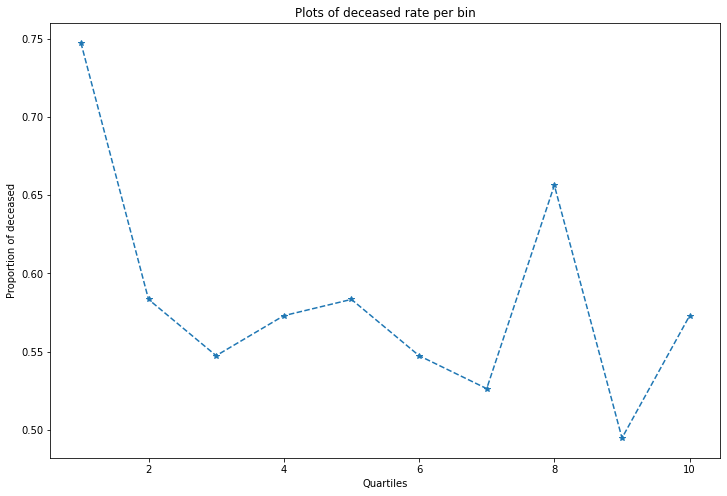

In [241]:
# Binarize days of ICUs into bins, and the deceased rate 
nbin = 10
bintick = np.linspace(0,1,num=nbin+1, endpoint=True)
binlabel = ["%sQ" %(str(i+1)) for i in range(nbin)]
quartiles = newdf["days_in_icu"].quantile(bintick).tolist()
newdf["quartiles"] = pd.cut(newdf["days_in_icu"], bins = quartiles, labels = binlabel)
mean_lst = []
for i in range(nbin):
    deceased_rate = np.mean(newdf[newdf["quartiles"] == str(i+1)+"Q"]["deceased"])
    mean_lst.append(deceased_rate)
ax, fig = plt.subplots(figsize = (12,8))
plt.plot(np.arange(1,nbin+1,1), mean_lst, "*--")
plt.xlabel("Quartiles")
plt.ylabel("Proportion of deceased")
plt.title("Plots of deceased rate per bin")

In [43]:
pre_inicu_df.to_csv("pre_inicu_df.csv")

In [70]:
# Time stamps for patients before admitted
# Most patients have fewer than 10 timestamps. 
pd.Series(pre_inicu_df.groupby("pt")["t"].nunique()).describe()

count    1010.000000
mean       30.047525
std       126.637296
min         2.000000
25%         6.000000
50%         8.000000
75%        10.000000
max      1829.000000
Name: t, dtype: float64

In [102]:
# Examine why some patients have different number of timestamps
thresh = 15
mask = pre_inicu_df.groupby("pt")["t"].nunique() > thresh
temp = pre_inicu_df[pre_inicu_df["pt"].isin(mask[mask].index)]
temp[temp["pt"] == 103]["t"].loc[13329:].min() - temp[temp["pt"] == 103]["t"].loc[13329:].max()

-1577713.0

In [261]:
# Main question: Don't know which clinical characteristics are relevant
pre_inicu_df[pre_inicu_df["event"] == "chart:eye:opening"]

,pt,t,event,value


In [167]:
len(newdf["days_in_icu"].quantile(bintick).tolist())

10

In [338]:
# Most common operaions per patient 
pt_freq_op.xs("urine out foley:ml", level = "event")

pt
9.0               1100
304.0              250
2149.0            1600
3974.0             210
5232.0             950
5610.0      [265, 630]
5987.0             120
6568.0            1000
7538.0             800
7737.0             200
9293.0            1100
10768.0            100
11349.0    [5000, 800]
11746.0             80
12056.0            250
12508.0            100
12767.0            800
13107.0            100
14798.0            165
15041.0            400
16178.0             []
16641.0            260
17184.0            500
18152.0      [140, 80]
18404.0            300
18731.0            250
20193.0            130
21669.0             80
22358.0      [175, 90]
22606.0            700
23651.0            200
26511.0            700
27821.0           1900
28523.0            115
31072.0           1100
Name: value, dtype: object

In [457]:
# Relevant variable 
# "chart:verbal response:" chart:level of consciousness
# Irrelevant: 
# Can extract: Religion, chart
pre_inicu_df[pre_inicu_df["event"] == "chart:level of consciousness:"]["value"].value_counts()

Alert                    1997
Arouse to Voice           896
Arouse to Stimul          368
Sedated                   336
Lethargic                 197
Sleeping                  191
Dozing Intermit           101
Unresponsive               78
Arouse to Pain             68
Paralytic Med              33
Confused                   33
Arouse to Stimulation      32
Other/Remarks               4
Name: value, dtype: int64

In [328]:
for i in range(nbin):
    deceased_rate = np.mean(newdf[newdf["quartiles"] == str(i+1)+"Q"]["deceased"])
    mean_lst.append(deceased_rate)
ax, fig = plt.subplots(figsize = (12,8))
plt.plot(np.arange(1,nbin+1,1), mean_lst, "*--")
plt.xlabel("Quartiles")
plt.ylabel("Proportion of deceased")
plt.title("Plots of deceased rate per bin")

,pt,age_at_admit,ethnic,gender,days_in_icu,fully_observed,deceased,in_m_out,de_m_in,quartiles
0,9.0,41.79,NA,m,5.3231,0,1,0,0,8Q
1,67.0,73.49,white,m,0.2148,0,1,0,1,1Q
2,81.0,85.06,white,m,1.5137,1,1,0,0,3Q
3,103.0,60.38,NA,f,0.7639,1,1,0,0,1Q
4,203.0,57.97,asian,m,9.5551,1,0,0,0,9Q
...,...,...,...,...,...,...,...,...,...,...
1005,99282.0,47.87,white,m,3.5522,1,0,0,0,7Q
1006,99286.0,57.17,black,f,3.6891,1,0,0,0,7Q
1007,99366.0,73.31,NA,m,7.7437,1,0,0,0,9Q
1008,99589.0,47.36,white,m,0.7933,1,0,0,0,1Q


In [368]:
# On average, patients have 30 timestamps. 75% patients have fewer than 10 timestamps prior to their admitance
# to ICU. When I examine if there are different tests run on each patient, the difference is not much.
# Different doctors order tests with different frequency. 
timestamp = pre_inicu_df.groupby(by = ["pt", "t"]).agg(pd.Series.nunique)
timestamp.reset_index()["t"].value_counts().describe()

count    30181.000000
mean         1.005533
std          0.074181
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: t, dtype: float64

In [826]:
# Pre-ICU, excluding birth information, what's the frequency at which eeach patient is examined.
# Summary statistics on how many events happen per stamps 
timestamp1 = df.groupby(by = ["pt"]).agg(pd.Series.count)
timestamp1["event_per_stamp"] = round(timestamp1["event"]/timestamp1["t"],2)
timestamp1["event_per_stamp"].describe()

count    1011.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: event_per_stamp, dtype: float64

In [841]:
# Total number of operations per timestamps
cdf = df
(cdf.groupby(by = ["pt"]).agg(pd.Series.count)["event"]/cdf.groupby(by = ["pt"]).agg(pd.Series.nunique)["t"]).describe()

count    1011.000000
mean       26.111245
std        11.529683
min         3.737408
25%        16.542896
50%        23.648649
75%        34.452668
max        61.252252
dtype: float64

In [842]:
cdf.groupby(by = ["pt"])["event"].agg(pd.Series.nunique).describe()

count    1011.000000
mean      417.312562
std       138.125539
min        40.000000
25%       313.000000
50%       391.000000
75%       502.500000
max       950.000000
Name: event, dtype: float64

In [823]:
# Per patients, how many different operations do they receive?
df.groupby(by = ["pt"])["event"].agg(pd.Series.nunique).describe()

count    1011.000000
mean      417.312562
std       138.125539
min        40.000000
25%       313.000000
50%       391.000000
75%       502.500000
max       950.000000
Name: event, dtype: float64

In [843]:
# Per patients, which events happen the most often?
temp = pre_inicu_df.groupby(by = ["pt", "event"]).agg(pd.Series.count)
temp.sort_values(by = ["t"], ascending = False).head(50)

t  value
pt      event                                       
2973.0  chart:heart rate:bpm              927    927
        chart:calprevflg:kg               916    916
        chart:spo2:%                      907    907
        chart:respiratory rate:bpm        900    900
9882.0  chart:spo2:%                      899    899
16020.0 chart:spo2:%                      890    890
2973.0  chart:heart rhythm:               872    872
        chart:ectopy type:                870    870
9882.0  chart:heart rate:bpm              870    870
        chart:calprevflg:kg               868    867
        chart:respiratory rate:bpm        864    864
2973.0  chart:precautions:                846    846
        chart:code status:                846    846
16020.0 chart:risk for falls:             845    845
        chart:service type:               841    841
        chart:heart rate:bpm              841    841
        chart:respiratory rate:bpm        839    839
        chart:code status:                837    837
        chart:precautions:                837    837
        chart:health care proxy:          837    837
        chart:calprevflg:kg               831    830
        chart:heart rhythm:               821    821
2973.0  chart:arterial bp systolic:mmhg   819    819
        chart:arterial bp diastolic:mmhg  819    819
16020.0 chart:ectopy type:                816    816
2973.0  chart:arterial bp mean:mmhg       814    814
9882.0  chart:heart rhythm:               807    807
        chart:ectopy type:                800    800
        chart:ectopy frequency:           795    795
3977.0  chart:heart rate:bpm              778    778
16020.0 chart:arterial bp systolic:mmhg   775    774
        chart:arterial bp diastolic:mmhg  774    774
        chart:resp alarm high:bpm         774    774
        chart:resp alarm low:bpm          774    774
        chart:spo2 alarm low:%            774    774
        chart:hr alarm low:bpm            774    774
        chart:hr alarm high:bpm           774    774
        chart:spo2 alarm high:%           774    774
        chart:nbp alarm low:mmhg          773    773
        chart:nbp alarm high:mmhg         773    773
        chart:arterial bp mean:mmhg       771    771
        chart:abp alarm low:mmhg          767    766
        chart:abp alarm high:mmhg         766    766
9882.0  chart:arterial bp systolic:mmhg   765    765
        chart:arterial bp diastolic:mmhg  764    764
        chart:precautions:                754    754
        chart:code status:                754    754
        chart:arterial bp mean:mmhg       749    749
2973.0  chart:service type:               737    737
3977.0  chart:heart rhythm:               731    731

In [514]:
# Per different operations, how many were applied to most patients? 
# In other words, what operations do most patients receive? 
# Dividing t with pt, you obtain average frequency of an event per patient?
pt_freq_op = pre_inicu_df.groupby(by = ["event"]).agg(pd.Series.nunique)
pt_freq_op = pt_freq_op.sort_values(by = ["pt"], ascending = False)[:50]

Text(0.5, 1.0, 'Plots of deceased rate per quartile')

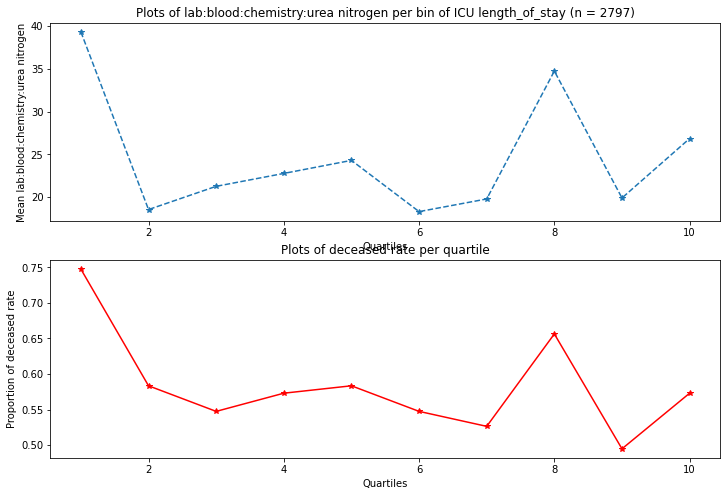

In [536]:
# Binarize variables related to the risk of strokes 
nbin = 10
event_name = pt_freq_op.index.tolist()[13]
mean_lst = []
deceased_lst = []
total_size = 0
for i in range(nbin):
    # Obtain index of patients per specific quartiles
    pt_in_q = newdf[newdf["quartiles"] == str(i+1)+"Q"]["pt"].tolist()
    temp = pre_inicu_df[pre_inicu_df["pt"].isin(pt_in_q)]
    # Convert all available values into numerics, dropping what is not available
    value_lst = pd.to_numeric(temp[temp["event"] == event_name]["value"], errors = "coerce").dropna()
    total_size += len(value_lst)
    mean = np.mean(value_lst.tolist())
    mean_lst.append(mean)
    
    # Plot deceased rate
    deceased_rate = np.mean(newdf[newdf["quartiles"] == str(i+1)+"Q"]["deceased"])
    deceased_lst.append(deceased_rate)

# Plot
fig, (ax1, ax2) = plt.subplots(2, figsize = (12,8), sharex = False, sharey = False)
ax1.plot(np.arange(1,nbin+1,1), mean_lst, "*--")
ax1.set_xlabel("Quartiles")
ax1.set_ylabel("Mean %s" %(event_name))
ax1.set_title("Plots of %s per bin of ICU length_of_stay (n = %d)" %(event_name, total_size))

ax2.plot(np.arange(1,nbin+1,1), deceased_lst, "*-", color = "red")
ax2.set_xlabel("Quartiles")
ax2.set_ylabel("Proportion of deceased rate")
ax2.set_title("Plots of deceased rate per quartile")


In [576]:
df[df["event"] == "marital_status:single"]

,pt,t,event,value
9862,67.0,5.930171e+09,marital_status:single,NaN
68391,970.0,6.240675e+09,marital_status:single,NaN
105500,1241.0,5.259390e+09,marital_status:single,NaN
155363,1353.0,5.561926e+09,marital_status:single,NaN
159419,1426.0,4.118670e+09,marital_status:single,NaN
...,...,...,...,...
8557092,92253.0,6.650459e+09,marital_status:single,NaN
8613499,93623.0,4.683716e+09,marital_status:single,NaN
8788928,98925.0,6.929780e+09,marital_status:single,NaN
8789547,98948.0,5.263900e+09,marital_status:single,NaN


In [590]:
df.groupby("event")["pt"].apply(list)["marital_status:single"]

[67.0,
 970.0,
 1241.0,
 1353.0,
 1426.0,
 2620.0,
 2921.0,
 2973.0,
 3831.0,
 3977.0,
 4023.0,
 4870.0,
 5389.0,
 5924.0,
 6432.0,
 6741.0,
 7538.0,
 7665.0,
 7683.0,
 7900.0,
 8172.0,
 8362.0,
 8605.0,
 8999.0,
 9077.0,
 9675.0,
 9718.0,
 9771.0,
 10465.0,
 10768.0,
 11233.0,
 11309.0,
 11349.0,
 11358.0,
 11746.0,
 11938.0,
 12488.0,
 13070.0,
 13638.0,
 13839.0,
 14003.0,
 14190.0,
 14798.0,
 15213.0,
 16192.0,
 16301.0,
 16302.0,
 16306.0,
 16405.0,
 16641.0,
 17184.0,
 17429.0,
 17761.0,
 18119.0,
 18152.0,
 18440.0,
 18546.0,
 19157.0,
 19168.0,
 19265.0,
 19655.0,
 19719.0,
 19790.0,
 20727.0,
 21048.0,
 21229.0,
 21564.0,
 21934.0,
 22107.0,
 22358.0,
 23222.0,
 23273.0,
 23716.0,
 24252.0,
 24919.0,
 25030.0,
 25475.0,
 27007.0,
 27309.0,
 27361.0,
 28062.0,
 28246.0,
 28500.0,
 28644.0,
 28925.0,
 29326.0,
 29825.0,
 30189.0,
 30450.0,
 30861.0,
 31169.0,
 31330.0,
 31670.0,
 31691.0,
 31742.0,
 31998.0,
 32356.0,
 32438.0,
 32440.0,
 32440.0,
 40007.0,
 40070.0,
 41984.0,
 

In [813]:
newdf

,pt,age_at_admit,ethnic,gender,days_in_icu,fully_observed,deceased,in_m_out,de_m_in,marital_status,religion,weight,height,behavior,judgement,balance,tidal_volume,hemoglobin,conscious
0,9.0,41.79,NA,m,5.3231,0,1,0,0,na,U,104,None,Sedated,None,None,None,12.899999618530273,Sedated
1,67.0,73.49,white,m,0.2148,0,1,0,1,single,JEW,65,None,Calm,None,None,None,None,Lethargic
2,81.0,85.06,white,m,1.5137,1,1,0,0,married,U,None,None,Appropriate,None,None,None,11.5,Alert
3,103.0,60.38,NA,f,0.7639,1,1,0,0,married,RCA,61.5,None,Calm,None,None,None,8.8000001907348633,Alert
4,203.0,57.97,asian,m,9.5551,1,0,0,0,married,U,62.400001525878906,None,Sedated,None,None,None,9.3000001907348633,Sedated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,99282.0,47.87,white,m,3.5522,1,0,0,0,single,Muslim,70,173,None,Intact,Steady,478,11.2,Unresponsive
1006,99286.0,57.17,black,f,3.6891,1,0,0,0,married,Not specified,68,None,None,None,None,None,12.1,None
1007,99366.0,73.31,NA,m,7.7437,1,0,0,0,na,Unknown,66,None,None,None,None,486,10.6,Unresponsive
1008,99589.0,47.36,white,m,0.7933,1,0,0,0,married,Roman Catholic,61.8,178,None,Intact,Steady,None,13.6,None


In [780]:
newdf["behavior"].isna().value_counts()

False    574
True     382
Name: behavior, dtype: int64

In [817]:
temp = df.groupby(["event", "pt"])["t"].agg(pd.Series.nunique).sort_values(ascending = False)

In [818]:
temp

event                                         pt     
chart:heart rate:bpm                          54073.0    14482
chart:respiratory rate:insp/min               54073.0    14466
chart:o2 saturation pulseoxymetry:%           54073.0    14411
chart:arterial blood pressure mean:mmhg       54073.0    11829
chart:arterial blood pressure diastolic:mmhg  54073.0    11779
                                                         ...  
chart:creatinine (0-1.3):                     28519.0        1
chart:unintentional weight loss >10 lbs.:     88309.0        1
                                              88532.0        1
chart:creatinine (0-1.3):                     28760.0        1
chart:creatinine:                             2973.0         1
Name: t, Length: 421903, dtype: int64